# Gemstones Price Prediction 

### Importing the necessary libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

### Load the Dataset path

In [9]:
# Load the .env file
load_dotenv()
datafile_path = os.getenv('data_file_path')


### setting some styling for the plots

In [100]:
sns.set_theme(style="dark")
sns.set_palette("RdPu_r")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Trebuchet MS'],
    'font.size': 12
})

### Loading the Dataset

In [10]:
data = pd.read_csv(datafile_path)

Displaying the first few rows of the dataset


In [11]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


The data appears to have been loaded correctly.

The `Unnamed: 0` column is unnecessary and will be removed.

In [103]:
data.drop(columns='Unnamed: 0',inplace=True)

# Data validation

###  Data types check

In [104]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

All the features seems to have the right datatype 

### Checking for duplicates

In [105]:
duplicated_mask = data.duplicated()
len(data[duplicated_mask])

34

In [106]:
data.drop_duplicates(inplace= True)

There are 34 duplicate gemstone rows, which will be removed to avoid introducing bias into the model.

### validating the data to ensure they fall within the accepted range.

In [107]:
data.describe()

,carat,depth,table,x,y,z,price
count,26933.000000,26236.000000,26933.000000,26933.000000,26933.000000,26933.000000,26933.000000
mean,0.798010,61.745285,57.455950,5.729346,5.733102,3.537769,3937.526120
std,0.477237,1.412243,2.232156,1.127367,1.165037,0.719964,4022.551862
min,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,2375.000000
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,5356.000000
max,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000,18818.000000


All data values are positive and within a reasonable range; no extreme values were identified in any column.

### Checking for missing values

In [108]:
data.isna().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

The `depth` column contains missing values. We will investigate the nature of these missing values to determine the appropriate imputation strategy. 


In [109]:
data[data['depth'].isnull()].groupby('color').size()

color
D     76
E    124
F    117
G    132
H    111
I     95
J     42
dtype: int64

In [110]:
data[data['depth'].isnull()].groupby('clarity').size()

clarity
I1       10
IF       20
SI1     163
SI2     128
VS1     102
VS2     174
VVS1     48
VVS2     52
dtype: int64

In [111]:
data[data['depth'].isnull()].groupby('cut').size()

cut
Fair          24
Good          59
Ideal        270
Premium      192
Very Good    152
dtype: int64

After analyzing the relationship between categorical variables and missing values in the `depth` column, no patterns were found. This suggests that the values are likely Missing Completely At Random (MCAR). Given the relatively small number of missing values and the potential for bias introduced by imputation techniques like mean or median imputation, we will drop the rows containing missing values.

In [112]:
data.dropna(subset='depth',inplace= True)

In [113]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

### Outliers analysis- 1

In [114]:
# Get numeric columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Create empty DataFrame to store the analysis results
outlier_summary = pd.DataFrame(
    columns=['Column', 'Total Outliers', 'Outlier Percentage', 
            'Lower Bound', 'Upper Bound', 'Min', 'Max']
)

# Calculate outliers for each column
for i,column in enumerate(numeric_columns):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(data)) * 100
    
    # Add results to summary DataFrame
    outlier_summary.loc[i] = [
        column, 
        n_outliers,
        f"{pct_outliers:.2f}%",
        f"{lower:.2f}",
        f"{upper:.2f}",
        f"{outliers[column].min():.2f}",
        f"{outliers[column].max():.2f}"
    ]

# Display summary table
outlier_summary

,Column,Total Outliers,Outlier Percentage,Lower Bound,Upper Bound,Min,Max
0,carat,638,2.43%,-0.58,2.03,2.03,4.50
1,depth,1219,4.65%,58.75,64.75,50.80,73.60
2,table,309,1.18%,51.50,63.50,49.00,79.00
3,x,15,0.06%,1.96,9.29,0.00,10.23
4,y,14,0.05%,1.99,9.27,0.00,58.90
5,z,20,0.08%,1.19,5.75,0.00,8.06
6,price,1727,6.58%,-5671.50,11972.50,11975.00,18818.00


Handling outliers is not straightforward. While they might be removed or imputed, outliers can sometimes provide valuable context to the model. After considering the nature of gemstones and the fact that the outliers, while significant, are not extremely extreme and represent highly-priced gemstones, we have decided to retain them. This decision is based on their relatively low number and their potential to add valuable context to the model. By scaling or standardizing the columns and employing techniques like Ridge and Lasso regression, we will mitigate the impact of these outliers while preserving the added context they provide.

After performing feature engineering and data transformations, we will re-evaluate the data for any new outliers that may have emerged. 

### Multicollinearity Detection

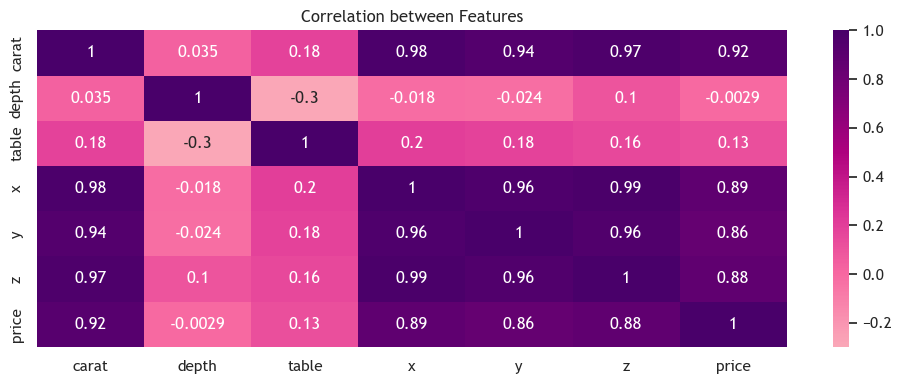

In [115]:
fig, axes = plt.subplots(figsize=(10, 4))
# Create summary heatmap
sns.heatmap(
    data[numeric_columns].corr(), 
    annot=True, 
    cmap='RdPu', 
    center=0
)
axes.set_title('Correlation between Features')
plt.tight_layout()


To address the high correlation between the x, y, and z columns, we will implement feature engineering by combining them into a new "volume" feature. This will fix the issue of multicollinearity among these variables. 

Additionally, given the correlation between the x, y, z, and carat features, we will employ regularization techniques like Ridge and Lasso regression to mitigate the impact of this correlation and improve model performance.

### Feature Engineering- 1

We will create a new "volume" feature by combining the x, y, and z columns. This will help address multicollinearity and improve overall model estimation.

In [116]:
data['volume'] = data['x'] * data['y'] * data['z']
data.drop(columns = ['x','y','z'],inplace = True)
data.head()

,carat,cut,color,clarity,depth,table,price,volume
0,0.30,Ideal,E,SI1,62.1,58.0,499,48.726678
1,0.33,Premium,G,IF,60.8,58.0,984,53.225640
2,0.90,Very Good,E,VVS2,62.2,60.0,6289,139.726944
3,0.42,Ideal,F,VS1,61.6,56.0,1082,68.482560
4,0.31,Ideal,F,VVS1,60.4,59.0,779,51.066825


### Checking for Linearity and Normality of Predictors

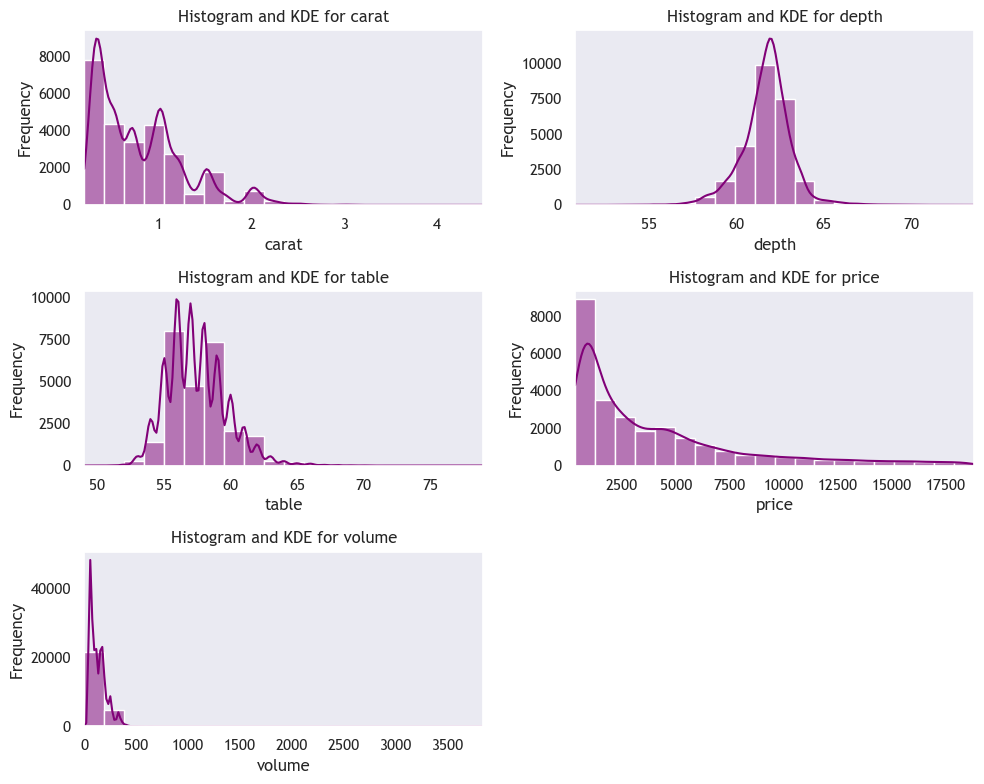

In [117]:
# Get numeric columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Create subplots
fig, axes = plt.subplots(3,2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, column in enumerate(numeric_columns):
    col_min = data[column].min()
    col_max = data[column].max()
    sns.histplot(data[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram and KDE for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(col_min, col_max)
# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

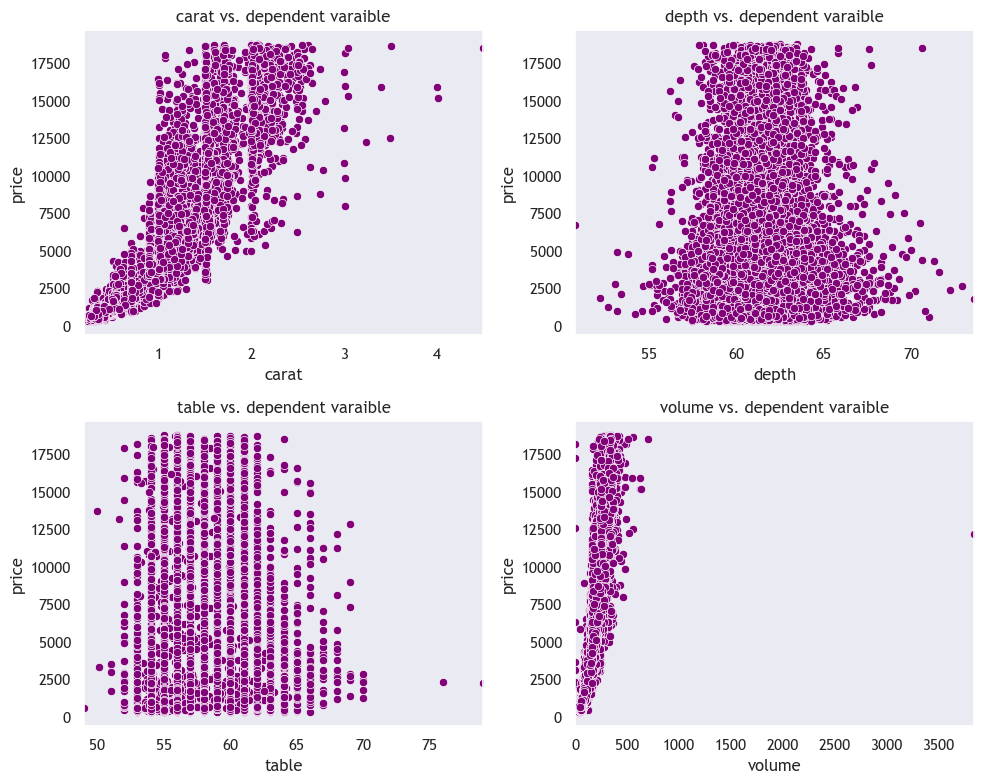

In [118]:
# Get numeric columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove('price')

#create a figure and axes objects
fig, axes = plt.subplots(2,2, figsize=(10,8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against the price  in a subplot
for index, column in enumerate(numeric_columns):
    col_min = data[column].min()
    col_max = data[column].max()
    axes[index].set_title(f"{column} vs. dependent varaible")
    sns.scatterplot(x= data[column], y = data['price'],ax = axes[index])
    axes[index].set_xlim(col_min, col_max)


fig.tight_layout()

After analyzing the relationships between the features and the target variable (price), we have observed that the `depth` and `table` features have weak or no correlation with the price. Therefore, we will consider removing these features to potentially improve model performance.

While the `volume` and `carat` features appear to have a linear relationship, the non-normal distribution of these features might be influencing this perception. To address this, we will apply a log transformation to the `price`, `volume`, and `carat` features. This transformation is suitable for right-skewed, positive-valued features. 

Following the transformation, we will re-evaluate the linearity and normality assumptions to ensure they are met. This will help us build a more accurate and reliable linear regression model.

### Feature Engineering- 2

In [119]:
#Applying log transformation to the columns
data['carat'] = np.log1p(data['carat'])
data['price'] = np.log1p(data['price'])
data['volume'] = np.log1p(data['volume'])

In [120]:
#Removing the depth and table columns
data.drop(columns = ['depth','table'],inplace = True)
data.head(1)

,carat,cut,color,clarity,price,volume
0,0.262364,Ideal,E,SI1,6.214608,3.906542


### Re-evaluation of the Linearity and Normality of Predictors

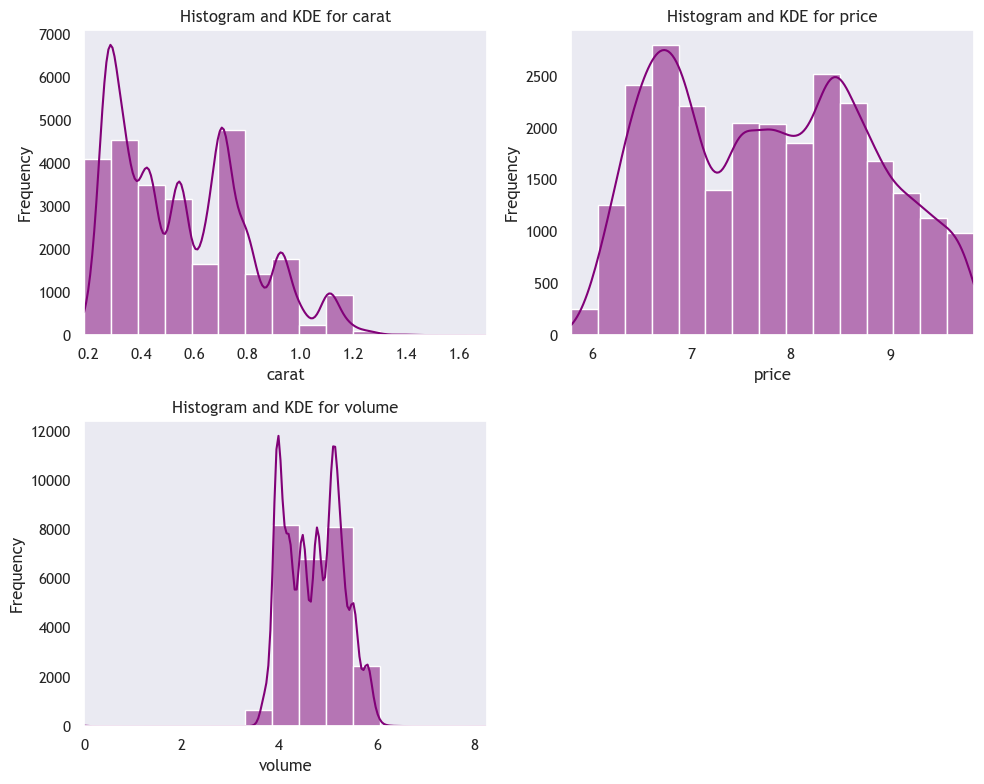

In [121]:
# Get numeric columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Create subplots
fig, axes = plt.subplots(2,2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, column in enumerate(numeric_columns):
    col_min = data[column].min()
    col_max = data[column].max()
    sns.histplot(data[column], bins=15, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram and KDE for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(col_min, col_max)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()

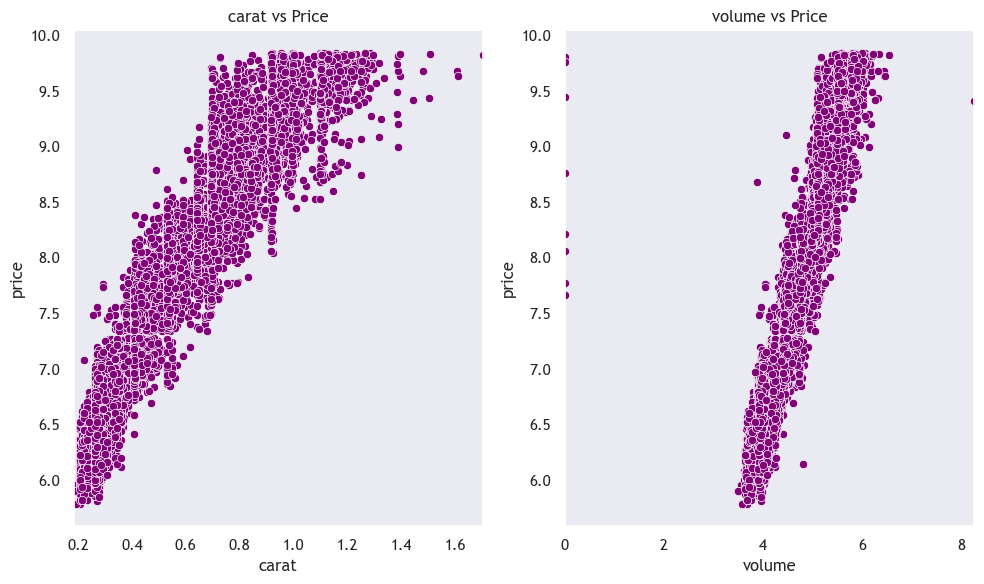

In [122]:
# Get numeric columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove('price')

#create a figure and axes objects
fig, axes = plt.subplots(1,2, figsize=(10,6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against the price  in a subplot
for index, column in enumerate(numeric_columns):
    col_min = data[column].min()
    col_max = data[column].max()
    axes[index].set_title(f"{column} vs Price")
    sns.scatterplot(x= data[column], y = data['price'],ax = axes[index])
    axes[index].set_xlim(col_min, col_max)

fig.tight_layout()

After applying the log transformation, we observe that the distribution of the features has improved, although it may not be perfectly normal. However, the most significant improvement is in the linear relationships between the predictors and the target variable. The relationships now appear much stronger and more linear.

It's important to note that the transformation might have affected the outlier behavior. We will need to re-evaluate the data for outliers and determine if any further actions, such as capping or removing, are necessary.

### Outliers Analysis-2

In [123]:
# Get numeric columns
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

# Create empty DataFrame to store the analysis results
outlier_summary = pd.DataFrame(
    columns=['Column', 'Total Outliers', 'Outlier Percentage', 
            'Lower Bound', 'Upper Bound', 'Min outlier value', 'Max outlier value']
)

# Calculate outliers for each column
for i,column in enumerate(numeric_columns):
    # calculate the q1, q3 and iqr
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # calculate the upper and lower range of the outliers
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    #find the outliers in each column
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(data)) * 100
    
    # Add results to summary DataFrame
    outlier_summary.loc[i] = [
        column, 
        n_outliers,
        f"{pct_outliers:.2f}%",
        f"{lower:.2f}",
        f"{upper:.2f}",
        f"{outliers[column].min():.2f}",
        f"{outliers[column].max():.2f}"
    ]

# Display summary table
outlier_summary

,Column,Total Outliers,Outlier Percentage,Lower Bound,Upper Bound,Min outlier value,Max outlier value
0,carat,29,0.11%,-0.24,1.29,1.29,1.70
1,price,0,0.00%,4.25,11.19,nan,nan
2,volume,9,0.03%,2.74,6.59,0.00,8.25


Based on the scatter plot and the analysis table, we can confirm that there are no outliers in the `price` column. While the `carat` column might have some outliers, they seem to be within a reasonable range and could potentially provide valuable context to the model. 

However, the `volume` column has extreme outliers that are visibly impacting the relationship with the `price` column. To mitigate the influence of these extreme outliers and improve the model's performance, we will remove them from the dataset.

In [124]:
# calculate the q1, q3 and iqr
Q1 = data['volume'].quantile(0.25)
Q3 = data['volume'].quantile(0.75)
IQR = Q3 - Q1
# calculate the upper and lower range of the outliers
upper = Q3 + (1.5 * IQR)
lower = Q1 - (1.5 * IQR)
#find the outliers in the column
outliers = data[(data['volume'] < lower) | (data['volume'] > upper)]
# Remove the outliers from the DataFrame
data = data[~((data['volume'] < lower) | (data['volume'] > upper))]

### Categorical Column Data Issues Check

In [125]:
data['color'].value_counts().sort_values()

color
J    1398
I    2670
D    3265
H    3979
F    4605
E    4792
G    5518
Name: count, dtype: int64

In [126]:
data['clarity'].value_counts()

clarity
SI1     6401
VS2     5918
SI2     4432
VS1     3984
VVS2    2478
VVS1    1791
IF       871
I1       352
Name: count, dtype: int64

In [127]:
data['cut'].value_counts()

cut
Ideal        10535
Premium       6687
Very Good     5875
Good          2375
Fair           755
Name: count, dtype: int64

We have verified that there are no inconsistencies in the categorical columns. This concludes the parts of our data analysis, transformation, and preprocessing steps that can be done **prior to the train-test split**. Any further preprocessing steps that could potentially introduce data leakage will be performed **after** the split.

To prevent data leakage, we will now proceed with a train-test split. This will divide our dataset into two subsets: a training set for model development and a testing set for unbiased evaluation.


### Train-Test split

In [128]:
# Import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Select the predictor variables (features) and the target variable
x = data[['carat', 'cut', 'color', 'clarity','volume']]
y = data[['price']]

# Split the dataset into training and testing sets
# test_size=0.2 means 20% of the data will be used for testing, and 80% for training
# random_state=3003 ensures reproducibility of the split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=3003)


### Variable Encoding

According to the data dictionary, our categorical columns are ordinal, meaning there's an inherent order between the categories. To preserve this order and effectively incorporate it into our model, we will use ordinal encoding. This technique assigns numerical values to categorical labels, reflecting their relative positions within the ordinal scale.

We will ensure that the encoder will be fitted only on the training data to avoid data leakage. Now, to improve model performance and facilitate the application of Ridge and Lasso regression, we will normalize or standardize the numerical features. This will scale the features to a common range, making them comparable and reducing the impact of features with larger scales.

### Normalization/Standardization

We're using two different scaling methods for our features. For regular numerical features, we'll use standardization, which centers the data around zero and keeps its original shape. For ordered categorical features, we'll use min-max scaling, which maps values between 0 and 1 while keeping their original order.

This approach helps the machine learning model understand and work with different types of data more effectively. By scaling features consistently, we make sure no single feature overpowers the others, which can help the model make better predictions.

### Creating a Transformation Pipeline

In [129]:
# Create a Transformation Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

# Define the order of categories for ordinal encoding
color_category_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
cut_category_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
clarity_category_order = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']

# List of categorical and numerical features
categorical_features = ['cut', 'color', 'clarity']
numerical_features = ['carat', 'volume']

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the categorical transformer using OrdinalEncoder
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[cut_category_order, color_category_order, clarity_category_order])),
    ('scaler',MinMaxScaler())
])

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the training data
x_train_preprocessed = preprocessor.fit_transform(x_train)

# Transform the test data
x_test_preprocessed = preprocessor.transform(x_test)

X_train_final = x_train_preprocessed
X_test_final = x_test_preprocessed

# Fiting the modle

## Simple Linear Regression

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [131]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_final, y_train)

LinearRegression()

In [132]:
# Make predictions on the training set
y_train_pred_mlr = model.predict(X_train_final)

# Make predictions on the test set
y_test_pred_mlr = model.predict(X_test_final)


In [133]:
# Calculate RMSE for training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_mlr))
# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_mlr))

# Calculate MAE for training set
mae_train = mean_absolute_error(y_train, y_train_pred_mlr)
# Calculate MAE for test set
mae_test = mean_absolute_error(y_test, y_test_pred_mlr)

# Calculate R² for training set
r2_train = r2_score(y_train, y_train_pred_mlr)
# Calculate R² for test set
r2_test = r2_score(y_test, y_test_pred_mlr)

# Print performance metrics
print(f'Training RMSE: {rmse_train}')
print(f'Test RMSE: {rmse_test}')
print(f'Training MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Training R²: {r2_train}')
print(f'Test R²: {r2_test}')

Training RMSE: 0.14948008777818275
Test RMSE: 0.15024815519326815
Training MAE: 0.11515491353776419
Test MAE: 0.11571843763453303
Training R²: 0.9784296385631494
Test R²: 0.978303538377193


## Ridge and Lasso

In [134]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

### Initializing Ridge and Lasso Models

In [135]:
#Initialize the Ridge and Lasso regression models.
ridge_model = Ridge()
lasso_modle = Lasso()

### Hyperparameter Tuning

We will be using scikit-learn's GridSearchCV to identify the optimal regularization parameters for Ridge and Lasso regression models. GridSearchCV works by searching through a predefined set of hyperparameter values, using cross-validation to evaluate each combination. The function creates a grid of parameter combinations and tests each one, automatically selecting the best performing configuration based on a specified scoring metric. By conducting a systematic search across different alpha values, we'll find the most effective regularization strength for both Ridge and Lasso regression. This approach ensures we find the ideal balance between model complexity and predictive performance, improving our model's generalization capabilities.

#### Defining Parameter Grids for Ridge and Lasso

In [136]:
# Define the parameter grid for Ridge
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0]}

# Define the parameter grid for Lasso
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0]}

#### Performing Grid Search with Cross-Validation

In [137]:
# Perform Grid Search with Cross-Validation for Ridge
ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train_final, y_train)

# Perform Grid Search with Cross-Validation for Lasso
lasso_grid_search = GridSearchCV(lasso_modle, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0,
                                   100.0, 500.0, 1000.0, 5000.0, 10000.0]},
             scoring='neg_mean_squared_error')

#### Extracting Best Hyperparameters

In [138]:
# Best hyperparameters for Ridge
best_ridge_alpha = ridge_grid_search.best_params_['alpha']
print(f'Best alpha for Ridge: {best_ridge_alpha}')

# Best hyperparameters for Lasso
best_lasso_alpha = lasso_grid_search.best_params_['alpha']
print(f'Best alpha for Lasso: {best_lasso_alpha}')

Best alpha for Ridge: 0.5
Best alpha for Lasso: 0.001


### Training the Ridge and Lasso Models

In [139]:
# Train the final Ridge model
best_ridge_model = Ridge(alpha=best_ridge_alpha)
best_ridge_model.fit(X_train_final, y_train)

# Train the final Lasso model
best_lasso_model = Lasso(alpha=best_lasso_alpha)
best_lasso_model.fit(X_train_final, y_train)

Lasso(alpha=0.001)

### Making Predictions 

In [140]:
# Make predictions
y_train_pred_ridge = best_ridge_model.predict(X_train_final)
y_test_pred_ridge = best_ridge_model.predict(X_test_final)

y_train_pred_lasso = best_lasso_model.predict(X_train_final)
y_test_pred_lasoo = best_lasso_model.predict(X_test_final)

### Evaluating the Models

In [141]:
# Evaluate the ridge model
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

# Calculate MAE for training set
mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
# Calculate MAE for test set
mae_test_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

# Calculate R² for training set
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
# Calculate R² for test set
r2_test_ridge= r2_score(y_test, y_test_pred_ridge)

# Evaluate the lasso model
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasoo))

# Calculate MAE for training set
mae_train_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
# Calculate MAE for test set
mae_test_lasso = mean_absolute_error(y_test, y_test_pred_lasoo)

# Calculate R² for training set
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
# Calculate R² for test set
r2_test_lasso = r2_score(y_test, y_test_pred_lasoo)

In [142]:
print(f'Ridge Training RMSE: {rmse_train_ridge}')
print(f'Ridge Test RMSE: {rmse_test_ridge}')
print(f'Ridge Training MAE: {mae_train_ridge}')
print(f'Ridge Test MAE: {mae_test_ridge}')
print(f'Ridge Training R²: {r2_train_ridge}')
print(f'Ridge Test R²: {r2_test_ridge}')

print(f'lasoo Training RMSE: {rmse_train_lasso}')
print(f'lasoo Test RMSE: {rmse_test_lasso}')
print(f'lasoo Training MAE: {mae_train_lasso}')
print(f'lasoo Test MAE: {mae_test_lasso}')
print(f'lasoo Training R²: {r2_train_lasso}')
print(f'lasoo Test R²: {r2_test_lasso}')

Ridge Training RMSE: 0.1494802064797385
Ridge Test RMSE: 0.15024895750249606
Ridge Training MAE: 0.11515183065275521
Ridge Test MAE: 0.11571847410906173
Ridge Training R²: 0.9784296043052556
Ridge Test R²: 0.9783033066629622
lasoo Training RMSE: 0.14967175403159327
lasoo Test RMSE: 0.15051650297192792
lasoo Training MAE: 0.11510477946084186
lasoo Test MAE: 0.11578399107458567
lasoo Training R²: 0.9783742872321585
lasoo Test R²: 0.9782259680857701


### Cross-validation 

We will be implementing cross-validation for our regression models using KFold technique. By dividing the dataset into 5 equal subsets, we systematically assess the performance of Multiple Linear Regression (MLR), Ridge, and Lasso Regression models. The cross-validation process evaluates three critical metrics: Negative Mean Squared Error, Root Mean Squared Error (RMSE), and R² Score, providing a statistical method to validate model performance. This approach helps mitigate overfitting, reduces potential bias from single train-test splits, and delivers a more reliable estimate of each model's true predictive power. This method enables us to confidently compare and select the most effective regression model for gems price prediction.

In [143]:
# Import required library
from sklearn.model_selection import cross_val_score, KFold

# Define cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=3003)

# Perform cross-validation
# MLR
mlr_neg_mse = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='neg_mean_squared_error')
mlr_rmse_cv = np.sqrt(-mlr_neg_mse)
mlr_r2_cv = cross_val_score(model, X_train_final, y_train, cv=cv, scoring='r2')

# Ridge
ridge_neg_mse = cross_val_score(best_ridge_model, X_train_final, y_train, cv=cv, scoring='neg_mean_squared_error')
ridge_rmse_cv = np.sqrt(-ridge_neg_mse)
ridge_r2_cv = cross_val_score(best_ridge_model, X_train_final, y_train, cv=cv, scoring='r2')

# Lasso
lasso_neg_mse = cross_val_score(best_lasso_model, X_train_final, y_train, cv=cv, scoring='neg_mean_squared_error')
lasso_rmse_cv = np.sqrt(-lasso_neg_mse)
lasso_r2_cv = cross_val_score(best_lasso_model, X_train_final, y_train, cv=cv, scoring='r2')

### Summary of Model Performance Metrics

In [144]:
metrics = [
    {'Model': 'MLR', 'Dataset': 'Training', 'RMSE': rmse_train, 'MAE': mae_train, 'R²': r2_train, 'CV_RMSE': mlr_rmse_cv.mean(), 'CV_R²': mlr_r2_cv.mean()},
    {'Model': 'MLR', 'Dataset': 'Test', 'RMSE': rmse_test, 'MAE': mae_test, 'R²': r2_test, 'CV_RMSE': mlr_rmse_cv.mean(), 'CV_R²': mlr_r2_cv.mean()},
    {'Model': 'Ridge', 'Dataset': 'Training', 'RMSE': rmse_train_ridge, 'MAE': mae_train_ridge, 'R²': r2_train_ridge, 'CV_RMSE': ridge_rmse_cv.mean(), 'CV_R²': ridge_r2_cv.mean()},
    {'Model': 'Ridge', 'Dataset': 'Test', 'RMSE': rmse_test_ridge, 'MAE': mae_test_ridge, 'R²': r2_test_ridge, 'CV_RMSE': ridge_rmse_cv.mean(), 'CV_R²': ridge_r2_cv.mean()},
    {'Model': 'Lasso', 'Dataset': 'Training', 'RMSE': rmse_train_lasso, 'MAE': mae_train_lasso, 'R²': r2_train_lasso, 'CV_RMSE': lasso_rmse_cv.mean(), 'CV_R²': lasso_r2_cv.mean()},
    {'Model': 'Lasso', 'Dataset': 'Test', 'RMSE': rmse_test_lasso, 'MAE': mae_test_lasso, 'R²': r2_test_lasso, 'CV_RMSE': lasso_rmse_cv.mean(), 'CV_R²': lasso_r2_cv.mean()}
]

# Create the DataFrame
df_metrics = pd.DataFrame(metrics)

# Display the table
df_metrics

,Model,Dataset,RMSE,MAE,R²,CV_RMSE,CV_R²
0,MLR,Training,0.149480,0.115155,0.978430,0.149567,0.978401
1,MLR,Test,0.150248,0.115718,0.978304,0.149567,0.978401
2,Ridge,Training,0.149480,0.115152,0.978430,0.149567,0.978401
3,Ridge,Test,0.150249,0.115718,0.978303,0.149567,0.978401
4,Lasso,Training,0.149672,0.115105,0.978374,0.149757,0.978345
5,Lasso,Test,0.150517,0.115784,0.978226,0.149757,0.978345


# Interpretation of Models residuals plots

### Making Predictions and Calculating Residuals

In [145]:
# Make predictions for MLR
y_train_pred_mlr = model.predict(X_train_final).flatten()
y_test_pred_mlr = model.predict(X_test_final).flatten()

# Make predictions for Ridge
y_train_pred_ridge = best_ridge_model.predict(X_train_final).flatten()
y_test_pred_ridge = best_ridge_model.predict(X_test_final).flatten()

# Make predictions for Lasso
y_train_pred_lasso = best_lasso_model.predict(X_train_final).flatten()
y_test_pred_lasso = best_lasso_model.predict(X_test_final).flatten()

# Ensure y_train and y_test are Series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Calculate residuals for MLR
residuals_train_mlr = y_train - y_train_pred_mlr
residuals_test_mlr = y_test - y_test_pred_mlr

# Calculate residuals for Ridge
residuals_train_ridge = y_train - y_train_pred_ridge
residuals_test_ridge = y_test - y_test_pred_ridge

# Calculate residuals for Lasso
residuals_train_lasso = y_train - y_train_pred_lasso
residuals_test_lasso = y_test - y_test_pred_lasso

### Plotting Residuals

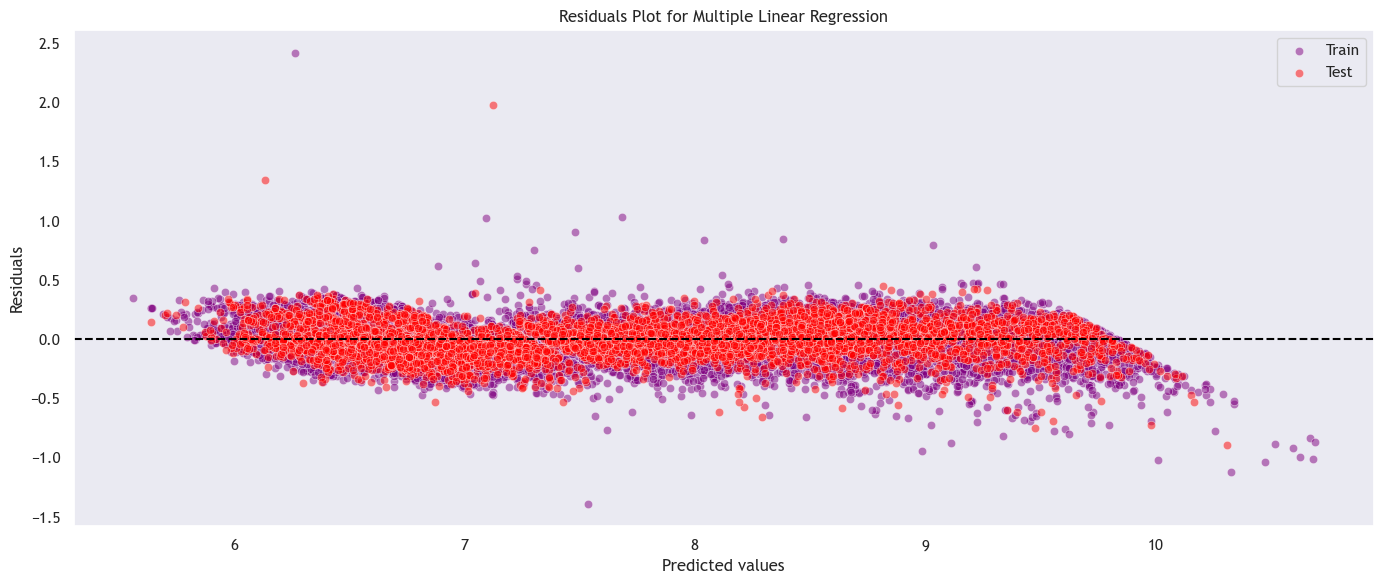

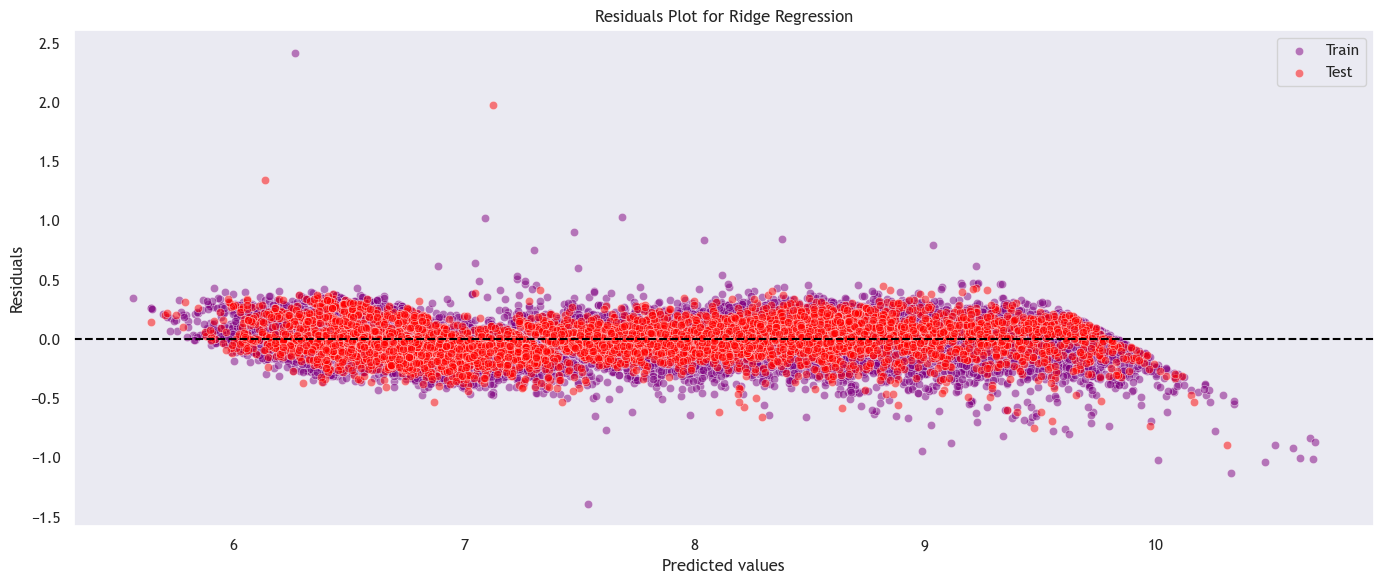

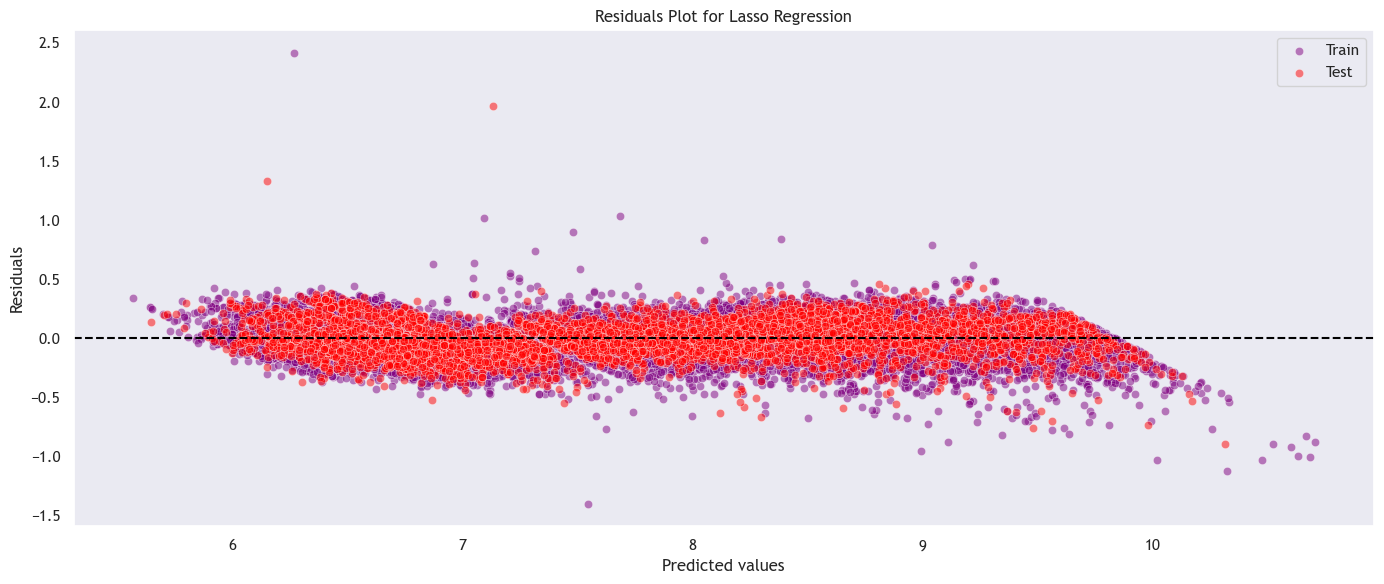

In [146]:
# Plot residuals for MLR
plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_train_pred_mlr, y=residuals_train_mlr, color="purple", alpha=0.5, label="Train")
sns.scatterplot(x=y_test_pred_mlr, y=residuals_test_mlr, color="red", alpha=0.5, label="Test")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="best")
plt.title("Residuals Plot for Multiple Linear Regression")
plt.tight_layout()
plt.show()

# Plot residuals for Ridge
plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_train_pred_ridge, y=residuals_train_ridge, color="purple", alpha=0.5, label="Train")
sns.scatterplot(x=y_test_pred_ridge, y=residuals_test_ridge, color="red", alpha=0.5, label="Test")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="best")
plt.title("Residuals Plot for Ridge Regression")
plt.tight_layout()
plt.show()

# Plot residuals for Lasso
plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_train_pred_lasso, y=residuals_train_lasso, color="purple", alpha=0.5, label="Train")
sns.scatterplot(x=y_test_pred_lasso, y=residuals_test_lasso, color="red", alpha=0.5, label="Test")
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals Plot for Lasso Regression")
plt.tight_layout()
plt.show()

**Multiple Linear Regression:**
The residuals plot for the Multiple Linear Regression model shows a fairly uniform spread of residuals around the zero line, indicating a good fit to the data. The residuals are evenly distributed across the range of predicted values, with no obvious patterns or systematic biases. The similarity between the training and test set residuals suggests the model has good generalization capabilities and is not overfitting the training data.

**Ridge Regression:**
The Ridge Regression model exhibits a very similar residuals plot to the Multiple Linear Regression model. The residuals are again evenly distributed around the zero line, with a consistent spread across the range of predictions. The alignment between the training and test set residuals further confirms the model's stability and ability to generalize well.

**Lasso Regression:**
The Lasso Regression model's residuals plot is also comparable to the previous two models. The residuals are symmetrically distributed around the zero line, with a consistent variance across the predicted values. The similarity between the training and test set residuals indicates the Lasso model has captured the underlying patterns in the data effectively and is not overfitting.

Overall, the residuals plots for all three regression models demonstrate a high degree of consistency and stability, with minimal systematic biases or heteroscedasticity issues. This suggests the models have been well-fitted to the data and can reliably predict the target variable.

# Interpretation of Model Performance Metrics

We evaluated three regression models **Simple Multiple Linear Regression (MLR)**, **Ridge Regression**, and **Lasso Regression** using performance metrics including Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), R² Score, and 5-fold Cross-Validation scores.

### Interpretation

#### Simple Multiple Linear Regression (MLR)

- **Consistency Across Datasets:** The RMSE (Train: 0.149, Test: 0.150) and MAE (Train: 0.116, Test: 0.116) values are very similar for both training and test datasets, indicating good generalization. This suggests the model is not overfitting and is able to make reliable predictions on new data.

- **Cross-Validation Performance:** The CV-RMSE (0.150) and CV-R² (0.978) closely match the train/test metrics, further confirming the model's stability across different data subsets. This adds confidence in the model's robustness and reliability.

- **Explained Variance:** An R² score of approximately 0.978 across all evaluations means that about 97.8% of the variance in the target variable is consistently explained by the model. This high R² score indicates a strong fit of the model to the data.

#### Ridge Regression

- **Performance Comparison:** The Ridge Regression model shows nearly identical performance metrics to MLR RMSE: Nearly identical to MLR (Train: 0.149, Test: 0.150), MAE: Extremely close to MLR (Train: 0.115, Test: 0.116), R² Score: Consistent at 0.978, including cross-validation scores (CV-RMSE: 0.150, CV-R²: 0.978). This similarity indicates that the model's performance is comparable to MLR in terms of accuracy and generalization.

- **Impact of Regularization:** The similarity between Ridge and MLR performance, even under cross-validation, suggests that multicollinearity is not a significant issue in the dataset. Ridge Regression's L2 regularization did not notably alter the model's performance, implying that the regularization did not need to address multicollinearity is also indicates Effective linear relationships between predictors.

- **Stability:** Consistent CV scores indicate that the L2 regularization neither improves nor deteriorates the model's performance. This further supports the model's robustness and ability to generalize well to unseen data.

#### Lasso Regression

- **Slight Performance Decrease:** The Lasso model shows marginally higher RMSE values (Train: 0.150, Test: 0.151, CV: 0.150), MAE: Marginally increased (Train: 0.115, Test: 0.116),R² Score: Minimal reduction (from 0.978 to 0.977), compared to MLR and Ridge. While the difference is minor, it indicates that Lasso Regression is slightly less accurate.

- **Cross-Validation Consistency:** The CV-RMSE (0.150) and CV-R² (0.978) scores remain close to the train/test metrics, indicating reliable performance. Despite the slight performance decrease, Lasso maintains consistent performance across different data subsets.

- **Feature Selection Effect:** While Lasso's L1 regularization may have eliminated some features, the minimal impact on CV scores suggests these features were not crucial for prediction. This indicates that Lasso might be useful for feature selection without significantly compromising model accuracy.

### Conclusion

- **Model Stability:** Cross-validation results confirm that all three models maintain consistent performance across different data subsets. This stability is crucial for ensuring reliable predictions on new data.

- **Best Performing Models:** MLR and Ridge Regression perform equally well, with nearly identical metrics in both direct validation and cross-validation. Given their similar performance, either model could be suitable for use depending on the specific requirements of the analysis.

- **Validation Confidence:** The alignment between traditional train/test metrics and cross-validation scores provides strong confidence in the models' generalization abilities. This consistency across metrics and validation methods ensures that the models are reliable and can be trusted for making predictions on new data.

Given the similar performance across all evaluation methods and lack of significant overfitting, the simpler Multiple Linear Regression model is most appropriate for this analysis. The simplicity of MLR makes it easier to interpret and implement, especially when regularization does not provide a notable performance improvement.

